## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['XLA_FLAGS'] = "--xla_disable_hlo_passes=constant_folding"
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np
from jax_tqdm import scan_tqdm
from jaxopt import GaussNewton
from sbs import sbs
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check CUDA devs

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
jax.devices()[0]

CudaDevice(id=0)

In [5]:
jax.devices()[0].memory_stats()

{'num_allocs': 0,
 'bytes_in_use': 0,
 'peak_bytes_in_use': 0,
 'largest_alloc_size': 0,
 'bytes_limit': 112516399104,
 'bytes_reserved': 0,
 'peak_bytes_reserved': 0,
 'largest_free_block_bytes': 0,
 'pool_bytes': 0,
 'peak_pool_bytes': 0}

## Declare circuit parameters

In [6]:
N = 120
T = 40

t_sqg = 56 #ns
t_reset = 100 #ns

In [7]:
linear_betas = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["betas"][7:]

In [8]:
linear_delays = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["total_ecd_times"][7:]

In [9]:
p = jnp.polyfit(linear_betas, linear_delays, 1)

## Sweep circuit parameters

In [10]:
delta = 0.43
sd_ratio = 1.6
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
vac = jqt.basis(2, 0) ^ jqt.basis(N, 0)
plus_Z = jqt.basis(2, 0) ^ gkp_qubit.basis["-x"]
initial_state = plus_Z

logical_Z = gkp_qubit.common_gates["X_0"]
freq_res = 4.138e9
freq_qb = 233e6
k_B = 1.380649e-23
h = 6.62607015e-34
T_res = 40e-3
T_qb = 40e-3
n_bar_qb = 1/(jnp.exp(h*freq_qb/k_B/T_qb)-1)
n_bar_res = 1/(jnp.exp(h*freq_res/k_B/T_res)-1)
error_channels = {
    "resonator": {
        "selfkerr": 0,
        "chi": 31.7e-6*2*jnp.pi,
        "T1": 89e3,
        "Tphi": 65e3*1e6,
        "n_bar": n_bar_res,
    },
    "fluxonium": {
        "T1": 93e3,
        "Tphi": 7e3,
        "n_bar": n_bar_qb,
        "reset_p_eg": 0.0783e-100,
        "reset_p_ee": 0.0783e-100,
        "t_rst": t_reset
    }
}

In [11]:
def fit_t1(times, amps, guess):
    def exponential(x, x_data, y_data):
        return y_data-x[0]*jnp.exp(x[1]*x_data)
    gn = GaussNewton(residual_fun=exponential, tol=1e-9, maxiter=1000)
    gn_sol = gn.run(guess, x_data=times, y_data=amps)
    return gn_sol.params, gn_sol.state.error

In [18]:
def comp_t1(qubit_t2, speedup):
    error_channels["fluxonium"]["Tphi"] = qubit_t2
    ts, res = sbs(initial_state = initial_state,
            delta=delta,
            sd_ratio=sd_ratio,
            T=T,
            observable=logical_Z,
            t_sqg = t_sqg,
            t_CD_floor = linear_delays[0],
            t_CD_p = p,
            t_rst=t_reset,
            error_channels=error_channels,
            speedup=speedup
            )
    fit_res = fit_t1(ts, jnp.abs(res), jnp.array([1., -1/60e3]))
    coeff = fit_res[0]
    residuals = fit_res[1]
    t1 = -1/coeff[1]
    return t1, res, ts, coeff, residuals

In [19]:
# deltas = jnp.linspace(0.2, 0.5, 15)
# sd_ratios = jnp.linspace(1, 3, 8)
speedup = jnp.array([1, 2, 3, 4, 5])
qubit_t2 = jnp.array([1, 2, 5, 10, 20, 50, 100]) * 7e3

In [20]:
vm_t1 = jax.vmap(comp_t1, in_axes=(0, None), out_axes=(0, 0, 0, 0, 0))

In [22]:
t1 = []
res = []
ts = []
coeff = []
residuals = []
for su in tqdm(speedup):
    im_t1, im_res, im_ts, im_coeff, im_residuals = vm_t1(qubit_t2, su)
    res.append(im_res)
    t1.append(im_t1)
    ts.append(im_ts)
    coeff.append(im_coeff)
    residuals.append(im_residuals)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [10:08<00:00, 121.80s/it]


In [23]:
t1 = jnp.stack(t1)/1e3

In [28]:
t1.squeeze().T

Array([[ 41.95872463,  51.78421297,  58.87127858,  64.47985087,
         69.19542497],
       [ 65.49074911,  82.71485907,  93.62618851, 101.89329898,
        108.71035154],
       [100.60494345, 125.83722421, 140.65652325, 151.62337699,
        160.6062869 ],
       [122.261499  , 151.16214638, 167.64181939, 179.77523297,
        189.72429295],
       [136.86463319, 167.75812094, 185.09468009, 197.84791188,
        208.32722139],
       [147.36395992, 179.46376216, 197.2993816 , 210.42579038,
        221.23421344],
       [151.21830675, 183.71479335, 201.71057861, 214.95991898,
        225.87910288]], dtype=float64)

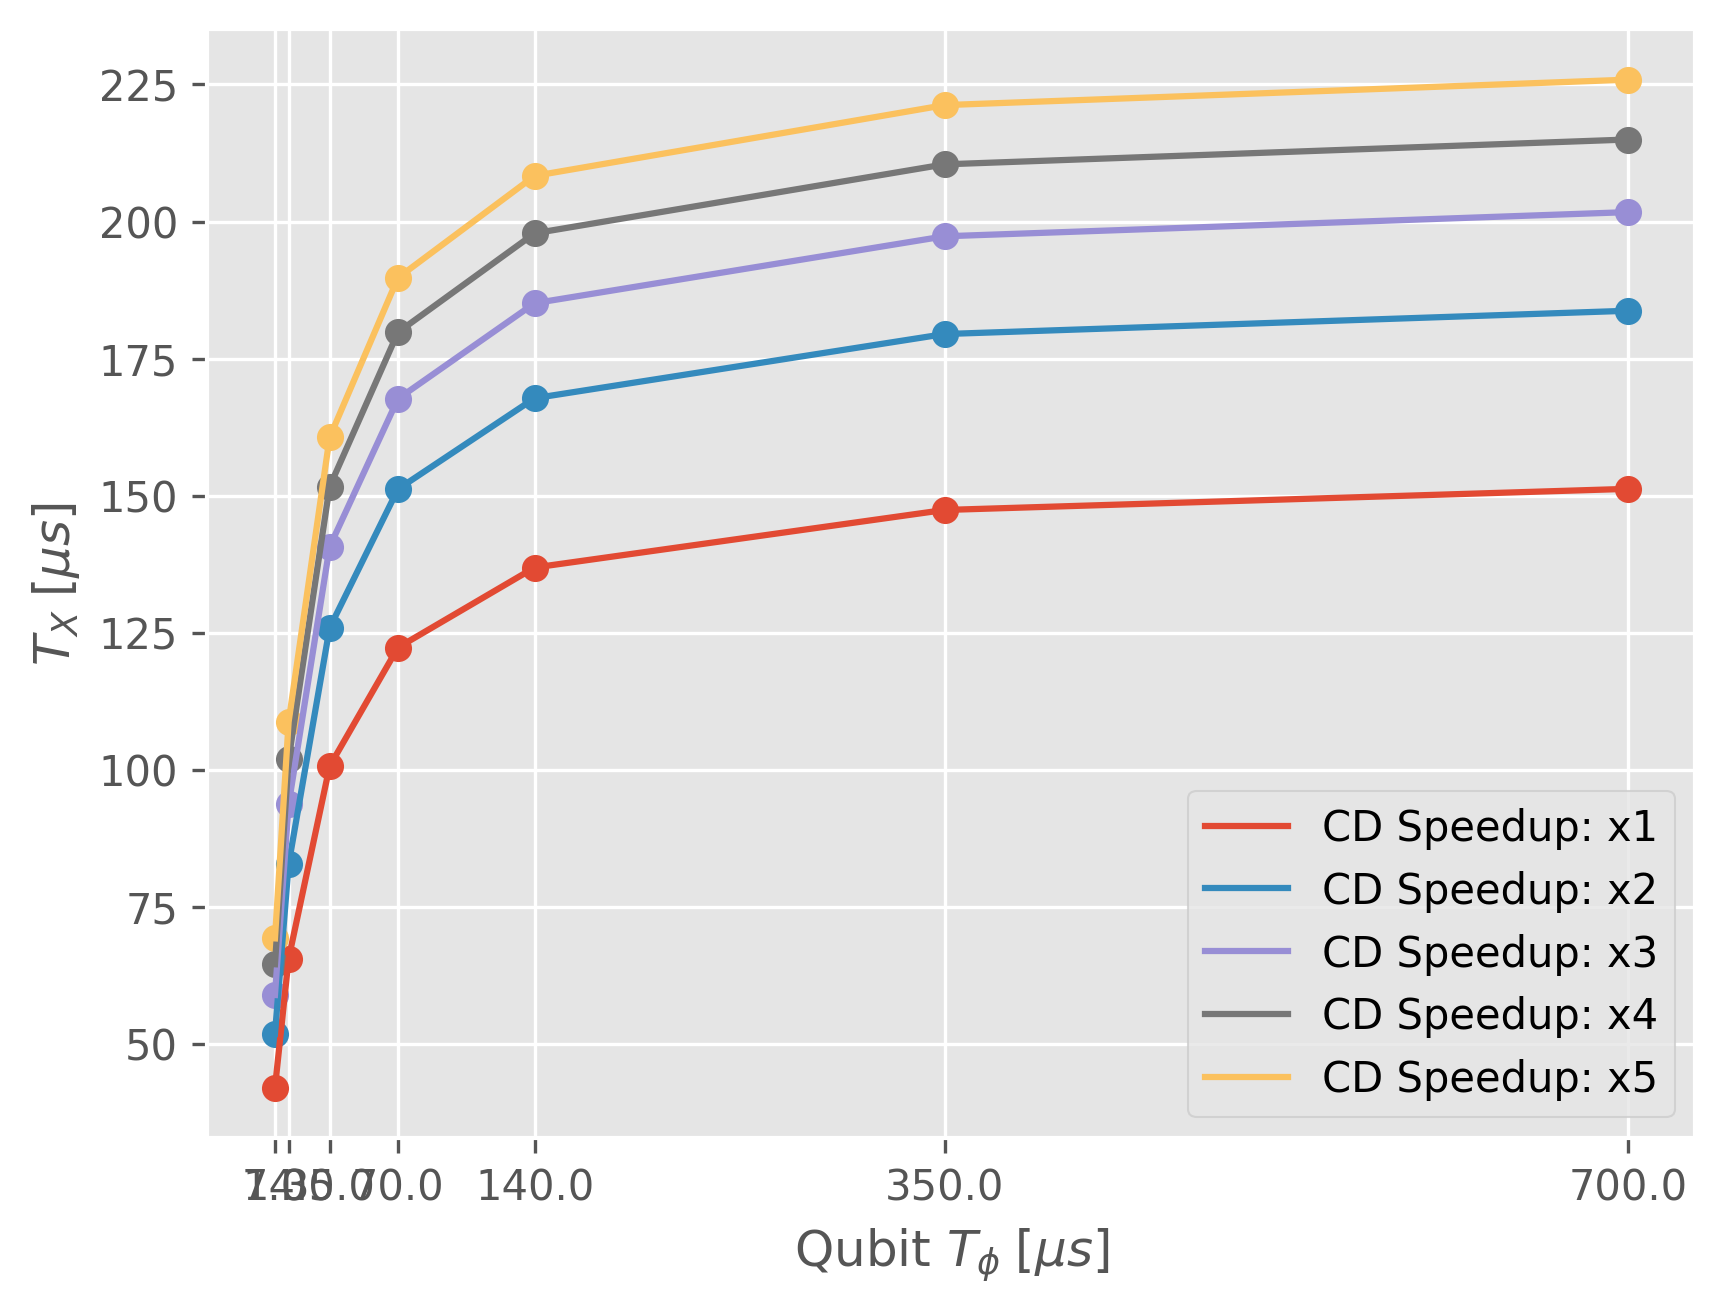

In [33]:
for t, su in zip(t1.squeeze(), speedup):
    plt.plot(qubit_t2*1e-3, t, label=f"CD Speedup: x{su}")
    plt.scatter(qubit_t2*1e-3, t)
plt.xscale("linear")
plt.xticks(qubit_t2*1e-3, qubit_t2*1e-3)
plt.xlabel("Qubit $T_{\phi} \; [\mu s]$")
plt.ylabel("$T_{X} \; [\mu s]$")
plt.legend()

In [136]:
res = jnp.stack(res)
ts = jnp.stack(ts)
coeff = jnp.stack(coeff)
residuals = jnp.stack(residuals)

In [137]:
deltas_mg, sd_ratios_mg = jnp.meshgrid(deltas, sd_ratios)

In [138]:
max_t1_idx = np.unravel_index(np.argmax(t1), t1.shape)
max_t1 = t1[max_t1_idx]
max_t1_delta = deltas_mg[max_t1_idx]
max_t1_sd_ratio = sd_ratios_mg[max_t1_idx]

TypeError: Dimensions of C (1, 7) are incompatible with X (15) and/or Y (1); see help(pcolormesh)

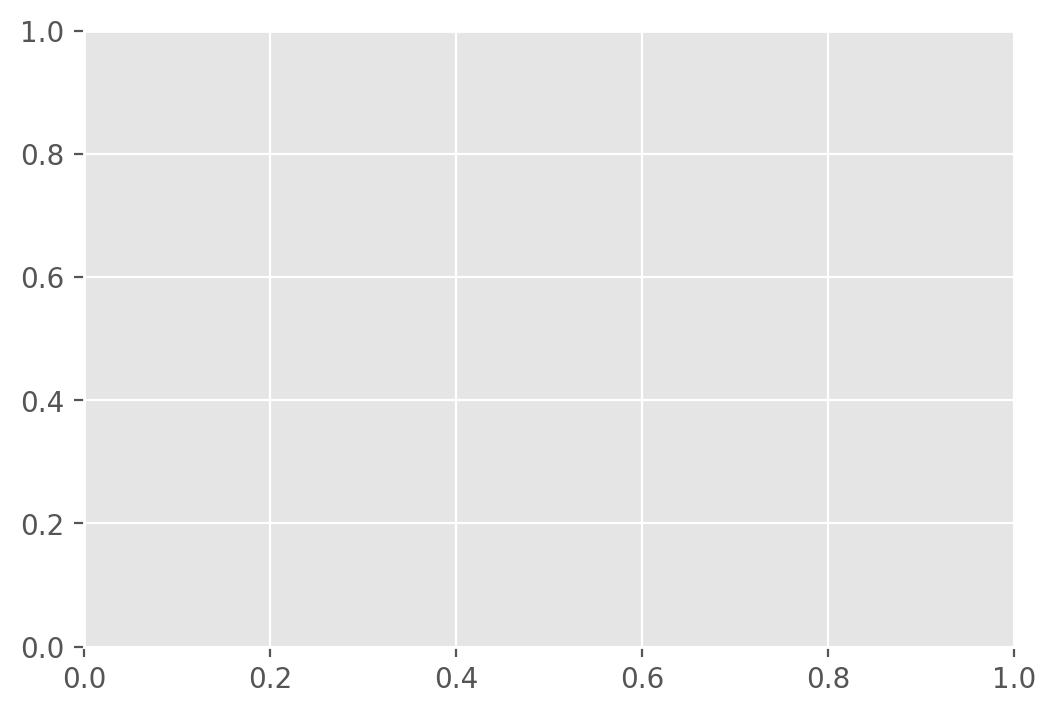

In [139]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=200)
handle = ax.pcolormesh(deltas_mg, sd_ratios_mg, t1, shading='nearest')
fig.colorbar(handle, ax=ax, label="Lifetime $[\mu s]$")
ax.scatter(max_t1_delta, max_t1_sd_ratio, color='red')
ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$\alpha_2 / \alpha_1$")
ax.set_title(f"Logical lifetime")


In [102]:
res.shape[:2]

(1, 7)

In [113]:
coeff

Array([[[ 8.54950161e-01, -2.04296625e-05],
        [ 8.49319375e-01, -1.32789029e-05],
        [ 8.48364588e-01, -8.89606386e-06],
        [ 8.49000792e-01, -7.46413050e-06],
        [ 8.49563341e-01, -6.75808790e-06],
        [ 8.49988249e-01, -6.33824266e-06],
        [ 8.50145234e-01, -6.19897615e-06]]], dtype=float64)

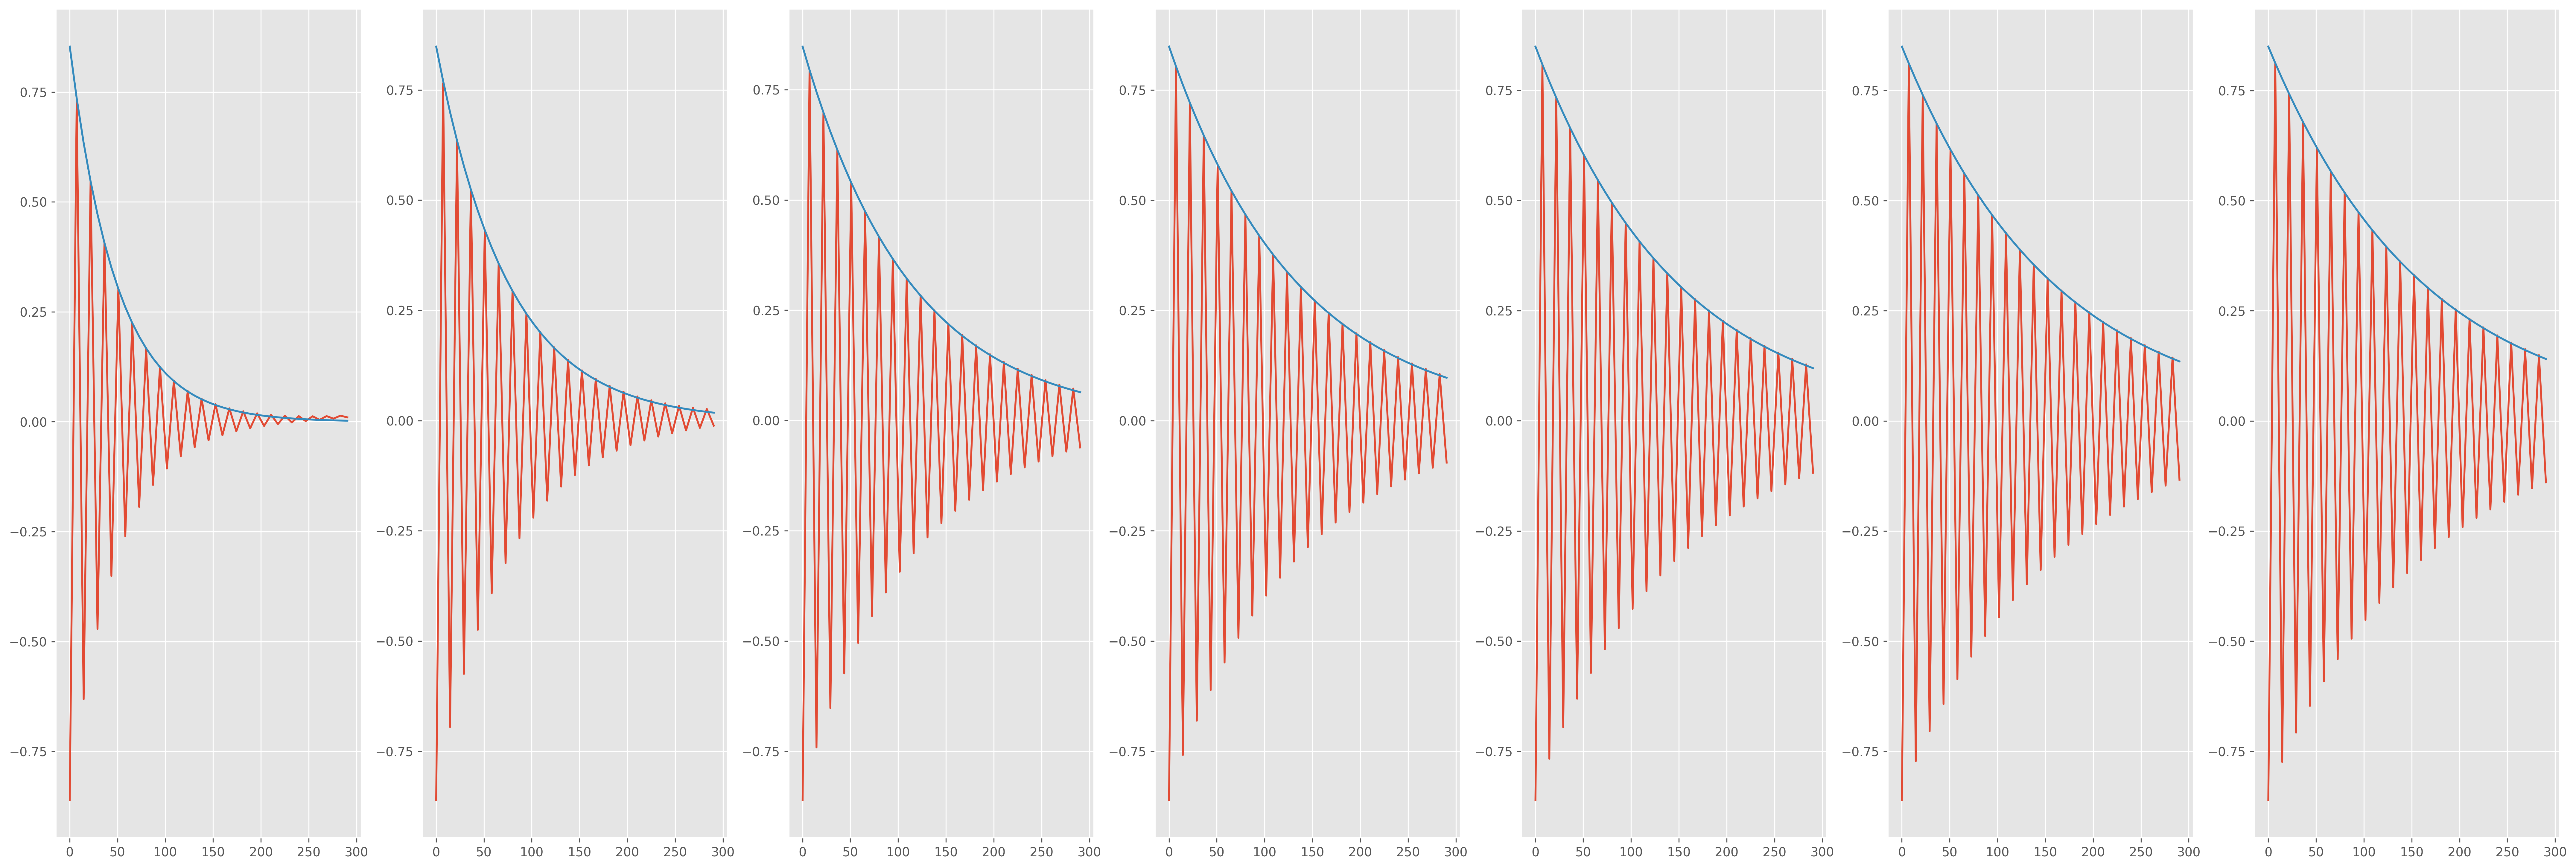

In [115]:
fig, axs = plt.subplots(*res.shape[:2], figsize=(36, 12))
for i in range(res.shape[1]):
    axs[i].plot(ts.squeeze()[i]/1e3, res[0, i])
    fit = coeff.squeeze()[i, 0]*jnp.exp(coeff.squeeze()[i, 1]*ts.squeeze()[i])
    axs[i].plot(ts[0, i]/1e3, fit)

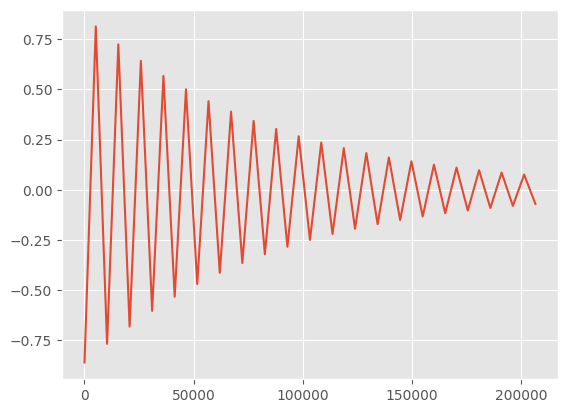

In [22]:
plt.plot(ts[max_t1_idx], res[max_t1_idx])